In [1]:
import torch
from torch_geometric.nn import GCNConv

# print torch versiona nd cuda version
print(torch.__version__)
print(torch.cuda.is_available())
#print cuda ver
print(torch.version.cuda)


1.10.0+cu102
True
10.2



# Comparison of segmentation and superpixel algorithms

This example compares four popular low-level image segmentation methods.  As
it is difficult to obtain good segmentations, and the definition of "good"
often depends on the application, these methods are usually used for obtaining
an oversegmentation, also known as superpixels. These superpixels then serve as
a basis for more sophisticated algorithms such as conditional random fields
(CRF).


## Felzenszwalb's efficient graph based segmentation
This fast 2D image segmentation algorithm, proposed in [1]_ is popular in the
computer vision community.
The algorithm has a single ``scale`` parameter that influences the segment
size. The actual size and number of segments can vary greatly, depending on
local contrast.

.. [1] Efficient graph-based image segmentation, Felzenszwalb, P.F. and
       Huttenlocher, D.P.  International Journal of Computer Vision, 2004


## Quickshift image segmentation

Quickshift is a relatively recent 2D image segmentation algorithm, based on an
approximation of kernelized mean-shift. Therefore it belongs to the family of
local mode-seeking algorithms and is applied to the 5D space consisting of
color information and image location [2]_.

One of the benefits of quickshift is that it actually computes a
hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: ``sigma`` controls the scale of the local
density approximation, ``max_dist`` selects a level in the hierarchical
segmentation that is produced. There is also a trade-off between distance in
color-space and distance in image-space, given by ``ratio``.

.. [2] Quick shift and kernel methods for mode seeking,
       Vedaldi, A. and Soatto, S.
       European Conference on Computer Vision, 2008


## SLIC - K-Means based image segmentation

This algorithm simply performs K-means in the 5d space of color information and
image location and is therefore closely related to quickshift. As the
clustering method is simpler, it is very efficient. It is essential for this
algorithm to work in Lab color space to obtain good results.  The algorithm
quickly gained momentum and is now widely used. See [3]_ for details.  The
``compactness`` parameter trades off color-similarity and proximity, as in the
case of Quickshift, while ``n_segments`` chooses the number of centers for
kmeans.

.. [3] Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi,
    Pascal Fua, and Sabine Suesstrunk, SLIC Superpixels Compared to
    State-of-the-art Superpixel Methods, TPAMI, May 2012.


## Compact watershed segmentation of gradient images

Instead of taking a color image as input, watershed requires a grayscale
*gradient* image, where bright pixels denote a boundary between regions.
The algorithm views the image as a landscape, with bright pixels forming high
peaks. This landscape is then flooded from the given *markers*, until separate
flood basins meet at the peaks. Each distinct basin then forms a different
image segment. [4]_

As with SLIC, there is an additional *compactness* argument that makes it
harder for markers to flood faraway pixels. This makes the watershed regions
more regularly shaped. [5]_

.. [4] https://en.wikipedia.org/wiki/Watershed_%28image_processing%29

.. [5] Peer Neubert & Peter Protzel (2014). Compact Watershed and
       Preemptive SLIC: On Improving Trade-offs of Superpixel Segmentation
       Algorithms. ICPR 2014, pp 996-1001. :DOI:`10.1109/ICPR.2014.181`
       https://www.tu-chemnitz.de/etit/proaut/publications/cws_pSLIC_ICPR.pdf


In [4]:
#read tif image file
from PIL import Image 
import tifffile as tiff
import numpy as np
from utils import *
from skimage import future
fn_tif = "/home/uz1/data/geo/full_image/new_data/composites/Argentina_Area_4_Band-1_to_9_in_one_file.tif"
fn_img = "/home/uz1/data/imagenet_images/bird/9130086_48332028c8.jpg"
fn_mask = "/home/uz1/data/geo/full_image/new_data/out/anno/gimp_anno/X_Argentina_Area_4_ Region of interest with tile grid (50px).jpg"
img_tif = tiff.imread(fn_tif)
img = np.array(Image.open((fn_img)))[:,:,:3]
mask = np.array(Image.open((fn_mask)))
# permute channels to last dim
img_tif = img_tif.reshape(img_tif.shape[1], img_tif.shape[2], img_tif.shape[0])
#select only the first 3 chabnnels 
img_tif = img_tif[:,:,:]
print('Image tiff shape: ', img_tif.shape)
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)

Image tiff shape:  (500, 500, 9)
img shape:  (332, 499, 3)
mask shape:  (500, 500, 3)


In [ ]:
img=np.array(Image.open(train_dataset.slice_paths[1][1]))[:,:,:3]
import pickle
def open_pickled_file(fn):
  with open(fn, "rb") as f_in:
    arr_new = pickle.load(f_in)
  return arr_new
img_tif =open_pickled_file(train_dataset.raw_paths[1][1])

Felzenszwalb number of segments: 248
SLIC number of segments: 233
Quickshift number of segments: 560


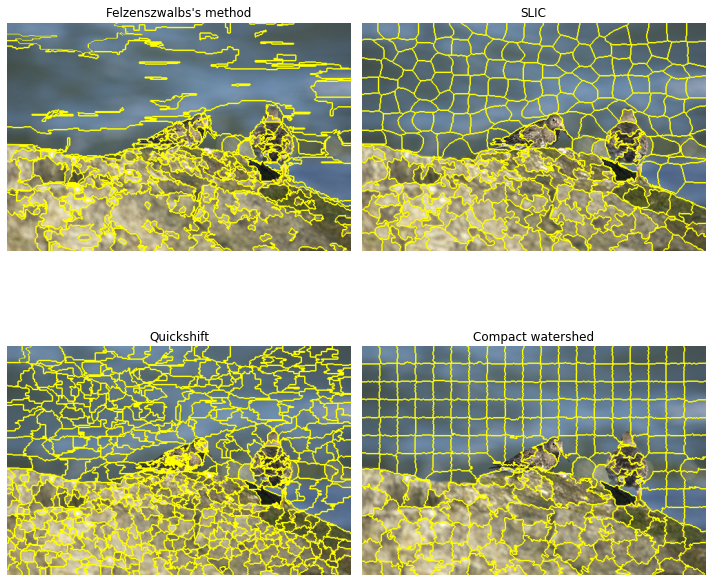

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import graph, data, io, segmentation, color
from matplotlib import pyplot as plt
from skimage.measure import regionprops
from skimage import draw
import numpy as np
mask[mask!=0] = 1
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

That means that each node will have a superpixel. each superpixel is a collection of pxiels 
which we can get by the previous code.
node representation begins by having the vector representation of the 
segment/superpixel, following depe stack of layers that change this representation into something more meaningful ?  

In [ ]:
Image.fromarray(segments_slic.astype(np.uint8)*100) # vis of annotaion generated / each pxiel gets an id of which segmetn it belogns to 

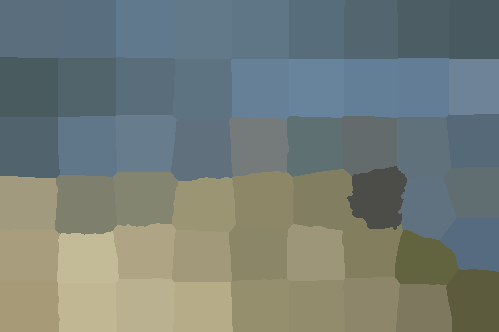

In [9]:

# img = np.array(Image.open(("/home/uz1/data/geo/full_image/new_data/out/X_Argentina_Area_2_ Region of interest with tile grid (50px).jpg")))[:,:,:3]
import PIL
labels = segmentation.slic(img, n_segments=50,compactness=100, sigma=1,
                     start_label=1)
# labels = labels + 1  # So that no labelled region is 0 and ignored by regionprops
label_rgb = color.label2rgb(labels, img, kind='avg')
regions = regionprops(labels)
PIL.Image.fromarray(label_rgb)
# here the projected regions extracted from the SLIC superpixel segmentation to the original image

In [25]:
import timm 
print(timm.__version__)

0.4.12


In [23]:
np.unique(labels,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([5041, 5041, 5041, 5041, 5041, 5112, 5183, 5041, 5041, 5041, 5041,
        5041, 5112, 5183, 5041, 5041, 5041, 5041, 5041, 5112, 5183, 5041,
        5041, 5041, 5041, 5041, 5112, 5183, 5041, 5041, 5041, 5041, 5041,
        5112, 5183, 5112, 5112, 5112, 5112, 5112, 5184, 5256, 5183, 5183,
        5183, 5183, 5183, 5256, 5329]))

In [ ]:

rag = rag_mean_band(img_tif, labels, connectivity=2, mode='similarity', sigma=255.0,ch=9)

In [ ]:
rag.nodes(data=True)[1]

In [ ]:
lc = future.graph.show_rag(labels, rag, img)


In [ ]:
pos= np.asarray([n[1]['centroid'] for n in rag.nodes.items()])


In [ ]:
x = np.asarray([n[1]['mean color'] for n in rag.nodes.items()])

In [ ]:
edge_index = np.asarray([[n1,n2] for (n1,n2) in rag.edges]).reshape(2,-1)#connectivity coodinates 


In [ ]:
weights = np.asarray([w[2]['weight'] for w in rag.edges.data()])

In [ ]:
rag.nodes[2],x[1]

# Torch geometric 

In [3]:

from torch_scatter import scatter_mean
from torch_geometric.data import Data
from skimage import graph, data, io, segmentation, color
from matplotlib import pyplot as plt
from skimage.measure import regionprops
from skimage import draw
import numpy as np
# tensor prep
import torch

In [4]:
import numpy as np
import PIL as pl 
from torch_geometric.transforms import BaseTransform
from skimage import future
from torch_scatter import scatter_min
class ImgToGraph(BaseTransform):
    r"""Converts an image to a superpixel representation using the
    :meth:`skimage.segmentation.slic` algorithm, resulting in a
    :obj:`torch_geometric.data.Data` object holding the centroids of
    superpixels in :obj:`pos` and their mean color in :obj:`x`
    (functional name: :obj:`to_slic`).

    This transform can be used with any :obj:`torchvision` dataset.

    Example::

        from torchvision.datasets import MNIST
        import torchvision.transforms as T
        from torch_geometric.transforms import ToSLIC

        transform = T.Compose([T.ToTensor(), ToSLIC(n_segments=75)])
        dataset = MNIST('/tmp/MNIST', download=True, transform=transform)

    Args:
        add_seg (bool, optional): If set to `True`, will add the segmentation
            result to the data object. (default: :obj:`False`)
        add_img (bool, optional): If set to `True`, will add the input image
            to the data object. (default: :obj:`False`)
        **kwargs (optional): Arguments to adjust the output of the SLIC
            algorithm. See the `SLIC documentation
            <https://scikit-image.org/docs/dev/api/skimage.segmentation.html
            #skimage.segmentation.slic>`_ for an overview.
    """
    def __init__(self, add_seg=False, add_img=False, **kwargs):
        self.add_seg = add_seg
        self.add_img = add_img
        self.kwargs = kwargs

    def __call__(self, img,mask,n_seg=250):
      segments_slic = segmentation.slic(img, n_segments=n_seg,compactness=10, sigma=1,
                          start_label=0)
    
      seg = torch.from_numpy(segments_slic)
      rag = rag_mean_band(img[:,:,:], segments_slic, connectivity=2, mode='similarity', sigma=255.0,ch=img.shape[2])

      img=torch.from_numpy(img)
            
      mask[mask!=0] = 1
      mask = torch.from_numpy(mask)[:,:,:1]
      h, w, c = img.shape
      # pinta ll shapes 
    #   print(seg.shape,img.shape,mask.shape)
      x = scatter_mean(img.view(h * w, c), seg.view(h * w), dim=0)

      pos_y = torch.arange(h, dtype=torch.float)
      pos_y = pos_y.view(-1, 1).repeat(1, w).view(h * w)
      pos_x = torch.arange(w, dtype=torch.float)
      pos_x = pos_x.view(1, -1).repeat(h, 1).view(h * w)

      pos = torch.stack([pos_x, pos_y], dim=-1)
      pos = scatter_mean(pos, seg.view(h * w), dim=0)


      edge_index = np.asarray([[n1,n2] for (n1,n2) in rag.edges]).reshape(2,-1)#connectivity coodinates 
      weights = np.asarray([w[2]['weight'] for w in rag.edges.data()])
      x = np.asarray([n[1]['mean color'] for n in rag.nodes.items()])
      node_class = scatter_min(mask.view(h*w),seg.reshape(h*w),dim=0)[0]

    #   lc = future.graph.show_rag(seg, rag, img[:,:,:3])

    #   pos= np.asarray([n[1]['centroid'] for n in rag.nodes.items()])


      data = Data(x=torch.from_numpy(x), pos=pos,edge_index=torch.tensor(edge_index),edge_weight=torch.tensor(weights).unsqueeze(1),y=node_class[:])

      return data

In [ ]:
imgtogr = ImgToGraph()
# img = np.array(pl.Image.open(("/content/pic-selected-220611-1534-43.png")))[:,:,:3]
mask = np.array(Image.open((fn_mask)))

data = imgtogr(img_tif,mask)
data

# scattering code

In [ ]:
img = np.array(pl.Image.open(("/content/pic-selected-220611-1534-43.png")))[:,:,:3]
mask = np.array(pl.Image.open(("//content/X_China_Area_1_Region of interest with tile grid (64px) (2).jpg")))


In [ ]:
img.shape,img_tif.shape,labels.shape

In [3]:
import torch

In [23]:
np.unique(segments_slic,return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [10]:
seg = torch.from_numpy(segments_slic)
h,w,c = img.shape
img = torch.from_numpy(img)
x = scatter_mean(img.view(h * w, c), seg.view(h * w), dim=0)

pos_y = torch.arange(h, dtype=torch.float)
pos_y = pos_y.view(-1, 1).repeat(1, w).view(h * w)
pos_x = torch.arange(w, dtype=torch.float)
pos_x = pos_x.view(1, -1).repeat(h, 1).view(h * w)

pos = torch.stack([pos_x, pos_y], dim=-1)
pos = scatter_mean(pos, seg.view(h * w), dim=0)

data = Data(x=x, pos=pos)

In [ ]:
data.edge_index = torch.tensor(edge_index)
data.pos=pos
data.edge_attr= torch.tensor(weights).unsqueeze(1)

# Visualise image graph


In [ ]:
# Install required packages.
import os
import torch 
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx


def visualize_graph(G, pos,color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.draw_networkx(G, pos=pos,node_color=color), with_labels=True,
                      cmap="Set2", node_color=color, edge_color="gray", node_size=10)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16,color='white')
    plt.show()
pos_dict = {e:[k,v] for e,(k,v) in enumerate(data.pos[:])}

In [ ]:
pos_dict = {e:[k,v] for e,(k,v) in enumerate(data.pos[:])}


In [ ]:
data.y[data.y==1] = 2
data.y[data.y==0] = 1
data.y[data.y==2] = 0

In [ ]:
# data=train_dataset[2]
G = to_networkx(data, to_undirected=True)
visualize_graph(G, pos=pos_dict,color=data.y) 

In [ ]:
data

# Build Network

In [28]:
d = torch.load("/home/uz1/projects/GCN/mnist/processed/train_data.pt")
print(d)

(Data(x=[4500000, 1], edge_index=[2, 83596613], y=[60000], pos=[4500000, 2]), defaultdict(<class 'dict'>, {'x': tensor([      0,      75,     150,  ..., 4499850, 4499925, 4500000]), 'edge_index': tensor([       0,     1399,     2659,  ..., 83593873, 83595207, 83596613]), 'y': tensor([    0,     1,     2,  ..., 59998, 59999, 60000]), 'pos': tensor([      0,      75,     150,  ..., 4499850, 4499925, 4500000])}))


In [37]:
d[1]

defaultdict(dict,
            {'x': tensor([      0,      75,     150,  ..., 4499850, 4499925, 4500000]),
             'edge_index': tensor([       0,     1399,     2659,  ..., 83593873, 83595207, 83596613]),
             'y': tensor([    0,     1,     2,  ..., 59998, 59999, 60000]),
             'pos': tensor([      0,      75,     150,  ..., 4499850, 4499925, 4500000])})

In [25]:
from torch_geometric.datasets import MNISTSuperpixels 
MNISTSuperpixels("/home/uz1/projects/GCN/mnist") 

Extracting /home/uz1/projects/GCN/mnist/raw/MNISTSuperpixels.zip
Processing...
Done!


MNISTSuperpixels(60000)

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GATConv(9, 3)
        self.conv2 = GATConv(3, 3)
        self.conv3 = GATConv(3 ,3)
        self.conv4 = GATConv(3 ,3)
        self.conv5 = GATConv(3 ,3)
        self.conv6 = GATConv(3 ,2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()
        h = self.conv5(h, edge_index)
        h = h.tanh()
        h = self.conv6(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        # x = global_mean_pool(x, x)  # [batch_size, hidden_channels]

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [33]:
from datasets import GeoGnn
transform =ImgToGraph()
train_dataset = GeoGnn(root="/home/uz1/data/geo/full_image/new_data/out",mask_root="/home/uz1/data/geo/full_image/new_data/out/anno/gimp_anno",tif_root="/home/uz1/data/geo/full_image/new_data/composites",transform=transform)

In [ ]:
model = GCN()
data = train_dataset[0]
print(data)
out, h = model(data.x.float(), data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [ ]:
from datasets import GeoFolders_2
DATASET_PATH ="/home/uz1/data/geo/slices/64"
import torch_geometric.transforms as T
transform =ImgToGraph()
p=1
train_dataset = GeoFolders_2(
root=DATASET_PATH,  transform=transform,raw_dir='/home/uz1/data/geo/slices_raw/64/',split="none",pick=p,k_labels_path=f'./k_labels_{p}.pickle')
valid_dataset = GeoFolders_2(
root=DATASET_PATH,  transform=transform,raw_dir='/home/uz1/data/geo/slices_raw/64/',split="valid",pick="China_Area_2")


In [32]:
import time
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GraphUNet
from torch.functional import F
model = GraphUNet(9,128,2,4,act=F.tanh)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
data_laoder = DataLoader(train_dataset,batch_size=128,shuffle=False)
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x.float(), data.edge_index)#,data.edge_weight.float())  # Perform a single forward pass.
    loss = criterion(out.softmax(-1), data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss,out

for epoch in range(1000):
    # track using tqdm
    tqdm_bar = tqdm(data_laoder)
    for i,data in enumerate(tqdm_bar):
        loss,out = train(data)
        if i % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
            #calculate acc
            pred = out.softmax(-1).argmax(-1)
            acc = (pred == data.y).float().mean()
            print(f'Accuracy: {acc.item():.4f}')
            print("Unique predictions ",np.unique(pred,return_counts=True))
            print("Unique labels ",np.unique(data.y,return_counts=True))
            # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
            # o = Data(x=h,pos=data.pos,edge_index=data.edge_index,edge_weight=data.edge_weight,y=out.softmax(dim=-1).argmax(dim=-1))
            # G=to_networkx(o, to_undirected=True)
            # pos_dict = {e:[k,v] for e,(k,v) in enumerate(o.pos[:])}
            # visualize_graph(G, pos=pos_dict,color=o.y)
            # time.sleep(0.3)

  0%|          | 0/273 [00:00<?, ?it/s]/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 1/273 [00:04<21:27,  4.73s/it]

Epoch: 0, Loss: 0.7014
Accuracy: 0.4634
Unique predictions  (array([0, 1]), array([4483, 3709]))
Unique labels  (array([0, 1], dtype=uint8), array([ 467, 7725]))


  4%|▍         | 11/273 [00:51<20:26,  4.68s/it]

Epoch: 0, Loss: 0.3239
Accuracy: 0.9894
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([0, 1], dtype=uint8), array([  87, 8105]))


  8%|▊         | 21/273 [01:39<20:10,  4.80s/it]

Epoch: 0, Loss: 0.3476
Accuracy: 0.9657
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([0, 1], dtype=uint8), array([ 281, 7911]))


 11%|█▏        | 31/273 [02:27<19:23,  4.81s/it]

Epoch: 0, Loss: 0.4818
Accuracy: 0.8314
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([0, 1], dtype=uint8), array([1381, 6811]))


 15%|█▌        | 41/273 [03:15<18:36,  4.81s/it]

Epoch: 0, Loss: 0.3133
Accuracy: 1.0000
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([1], dtype=uint8), array([8192]))


 19%|█▊        | 51/273 [04:02<17:17,  4.67s/it]

Epoch: 0, Loss: 0.3349
Accuracy: 0.9784
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([0, 1], dtype=uint8), array([ 177, 8015]))


 22%|██▏       | 61/273 [04:49<16:37,  4.70s/it]

Epoch: 0, Loss: 0.4644
Accuracy: 0.8489
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([0, 1], dtype=uint8), array([1238, 6954]))


 26%|██▌       | 71/273 [05:38<16:29,  4.90s/it]

Epoch: 0, Loss: 0.3133
Accuracy: 1.0000
Unique predictions  (array([1]), array([8192]))
Unique labels  (array([1], dtype=uint8), array([8192]))


 29%|██▉       | 79/273 [06:16<15:24,  4.77s/it]


SystemError: <method 'astype' of 'numpy.ndarray' objects> returned a result with an error set

Embedding shape: [8192, 2]


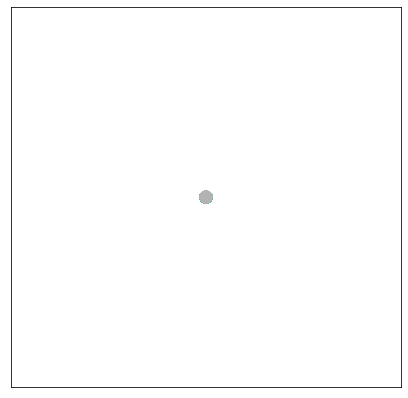

In [23]:

out= model(data.x.float(), data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=out.softmax(-1).argmax(-1))

In [ ]:
len(train_dataset)

In [ ]:
train_dataset[2]

In [30]:
out.softmax(-1).argmax(-1).shape

torch.Size([8192])

In [25]:
data.x.shape

torch.Size([8192, 9])

# Grap U Net ?

In [19]:
from torch_geometric.nn.models import GraphUNet


GraphUNet(9, 128, 2, depth=4, pool_ratios=[0.5, 0.5, 0.5, 0.5])